### Selecting Physical System and Run with Classical ODE Solve Method (20 pts)

YOUR SELECTED PHYSICAL SYSTEM AND ITS ODE EQUATION EXPLANATION HERE (in markdown) 

One-dimensional lattice with periodic boundary condition:

The hamiltonian of the problem is 
\begin{equation}
H(\mathbf x, \mathbf p) = \sum_{j=0}^{N-1}\frac{p_j^2}{2m_j} + \sum_{j=0}^{N-1}\frac{1}{2}{k_j}(x_j - x_{j+1})^2
\end{equation}
Where $\mathbf x=(x_0, ..., x_{N-1})$ and $\mathbf p=(p_0, ..., p_{N-1})$ are the canonical position and momentums, $m_0, ..., m_{N-1}$ are the masses of each particle, $k_0, ..., k_{N-1}$ are spring constant between $i$-th and $(i+1)$-th particle and $x_N:=x_0$ (periodic boundary condition).

Although the system it self is exatly solvable via diagonalization, letting $m_0, ..., m_{N-1} = m$ and $k_0, .., k_{N-1} = m\omega_0^2$ gives lattice-translation symmetry and make the system more easier.

In the homogeneous atomic chain, the Hamiltonian and be represented by
\begin{equation}
H(\mathbf x, \mathbf p) = \frac{1}{2m}\mathbf p^\top\mathbf p + \frac{1}{2}m\omega_0^2\mathbf x^\top \begin{pmatrix}
     2 & -1 &  0 & \cdots &  0 & -1 \\
    -1 &  2 & -1 & \cdots &  0 &  0 \\
     0 & -1 &  2 & \cdots &  0 &  0 \\
    \vdots&\vdots&\vdots&\ddots&\vdots&\vdots\\
     0 &  0 &  0 & \cdots &  2 & -1 \\
    -1 &  0 &  0 & \cdots & -1 & 2 \\ 
\end{pmatrix}
\mathbf x
\end{equation}

Since the system has lattice-translation symmetry, $H(x_0, x_1, x_2, ..., x_{N-1}, p_0, p_1, p_2, ..., p_{N-1})=H(x_{N-1}, x_0, x_1, ..., x_{N-2}, p_{N-1}, p_0, p_1, ..., p_{N-2})$, the canonical transformation might be helpful.
\begin{equation}
    X_j = \sum_{k=0}^{N-1} x_i e^{-2\pi ij/N}
    ,\quad
    P_j = \sum_{k=0}^{N-1} p_i e^{-2\pi ij/N}
\end{equation}
The hamiltonian changes:
\begin{equation}
    H = \sum_{j=0}^{N} \left(\frac{P_j^2}{2m} + \frac{1}{2}\omega_j^2X_j^2\right)
\end{equation}
Where $\omega_j = 2\omega_0 \sin^2(j\pi/N)$

Hence, the solution is
\begin{equation}
    x_k(t) = \sum_{j=0}^{N-1} A_j e^{2\pi ij/N + i\omega_jt}
    ,\quad
    p_k(t) = \sum_{j=0}^{N-1} B_j e^{2\pi ij/N + i\omega_jt}
\end{equation}

Where $A_j$ and $B_j$ are fourier transformation of initial condition:
\begin{equation}
    A_j = \sum_{k=0}^{N-1} x_i(0) e^{-2\pi ij/N}
    ,\quad
    B_j = \sum_{k=0}^{N-1} p_i(0) e^{-2\pi ij/N}
\end{equation}

In [1]:
import jax
import jax.numpy as jnp

# INITIAL CONDITIONS
N = 64
m = jnp.full((N,), 1.)
k = jnp.full((N,), 125.)
c = jnp.sqrt(k / m)

left_shifted = jnp.arange(1, N + 1, dtype=jnp.int32) % N
right_shifted = jnp.arange(-1, N - 1, dtype=jnp.int32) % N

def _kinetic(p, m):
    return jnp.sum(p ** 2) / (2 * m)

def _potential(x, k):
    return (1/2) * k * jnp.sum((x - x[left_shifted]) ** 2)

def _hamiltonian(x, p, m, k):
    return _kinetic(p, m) + _potential(x, k)

kinetic = jax.jit(_kinetic)
potential = jax.jit(_potential)
hamiltonian = jax.jit(_hamiltonian)

t0 = 0
t1 = 20
dt0 = 1e-2

# parameters for gaussian envelope
amp = 2
loc = 31
sigma = 3

# YOUR INITIAL CONDITIONS HERE
def gaussian_envelope(x, amp, loc, sigma):
    return amp * (1 / jnp.sqrt(2 * jnp.pi * sigma ** 2)) * jnp.exp(-((x - loc) ** 2) / (2 * sigma ** 2))

x0 = jnp.zeros((N,))
p0 = jnp.zeros((N,))

indices = jnp.arange(-3 * sigma + loc, 3 * sigma + loc + 1, 1, dtype=jnp.int32) % N
dx = gaussian_envelope(jnp.linspace(-3 * sigma, 3 * sigma, 6 * sigma + 1), amp, 0, sigma)
dp = (m[indices] * c[indices] / (sigma ** 2)) * (jnp.linspace(-3 * sigma, 3 * sigma, 6 * sigma + 1)) * dx

x0 = x0.at[indices].add(dx)
p0 = p0.at[indices].add(dp)

x0 = x0 - jnp.mean(x0)
p0 = p0 - jnp.mean(p0)

# ODE FUNCTION
def _grad_kinetic(p, m):
    return p / m

def _grad_potential(x, k):
    return k * (2 * x - x[left_shifted] - x[right_shifted])

grad_kinetic = jax.jit(_grad_kinetic)
grad_potential = jax.jit(_grad_potential)

# def f_vec(r,t):
#     YOUR CODE FOR ODE HERE

def f(t, z, args):
    x, p = z
    m, k = args
    return (grad_kinetic(p, m), -grad_potential(x, k))

In [2]:
import diffrax # library for ODE solving
# SELECTED CLASSICAL METHOD FOR SOLVING ODE

# YOUR SELECTED METHOD HERE (e.g rksovle_apaptive() class in tutorial)

# def f(t, z, args):
#     (x, p) = z
#     return (p, -x)

term = diffrax.ODETerm(f)
solver = diffrax.Dopri8() # ODE Solving method is Dormand-Prince's 8/7 method, 8th order Explicit Runge-Kutta method.
saveat = diffrax.SaveAt(ts = jnp.linspace(t0, t1, int((t1 - t0) * 60) + 1)) # save the solution at 60 points per unit time. this not related to the step size.
stepsize_controller = diffrax.PIDController(rtol=1e-5, atol=1e-5) # take the step size adaptively by PID controller keeping the error tolerance relative=1e-5, absolute=1e-5. 

In [3]:
# SOLVE ODE

# YOUR SOLVE ODE CODE HERE

sol = diffrax.diffeqsolve(term, solver, t0=t0, t1=t1, dt0=dt0, y0=(x0, p0), saveat=saveat, args=(m, k),
                          stepsize_controller=stepsize_controller)
ts = sol.ts
xs, ps = sol.ys

In [4]:
import tqdm
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FFMpegWriter
# VISUALIZATION

def make_video(t, xs, ps, output_path, fps=60):
    """
    a_data, b_data: shape = (num_frames, N)
                    시간축으로 변화하는 a, b 데이터
    output_path: 출력할 mp4 경로
    fps: 초당 프레임 수
    """
    num_frames = len(t)
    
    # x축 index
    index = np.arange(N)

    # ---------- (1) 초기 그래프 설정 ----------
    # 첫 프레임(0) 기준으로 막대그래프를 그려두고, reference를 저장해 놓습니다.
    x = xs[0]
    p = ps[0]

    fig, ax = plt.subplots(figsize=(8, 5))
    
    # a, b 막대: grouped bar
    ax.plot(index, x, label='$x$')
    ax.plot(index, p, label='$p$')
    ax.set_xticks(index)
    ax.set_xlabel('Particle indices')
    ax.set_ylabel('displacement')
    ax.set_title(f't={t[0]:.2f}')
    ax.set_ylim(-2, 2)
    ax.legend()

    # ---------- (2) 프레임 업데이트 함수 정의 ----------
    def update(frame):
        # 해당 frame에서의 a, b
        t = ts[frame]
        x = xs[frame]
        p = ps[frame]
        
        # update curve data for x and p
        ax.lines[0].set_ydata(x)
        ax.lines[1].set_ydata(p)
        
        # 시간에 따라 타이틀 갱신
        ax.set_title(f't={t:.2f}')

    # ---------- (3) mp4로 저장 ----------
    writer = FFMpegWriter(fps=fps, metadata=dict(artist='Me'), bitrate=1800)
    with writer.saving(fig, output_path, dpi=100):
        # 전체 프레임 순회하며 그린 뒤 저장
        for frame in tqdm.trange(num_frames, desc="making video"):
            update(frame)
            writer.grab_frame()
    
    plt.close(fig)
    
# YOUR VISUALIZATION CODE HERE
from IPython.display import Video

video_path = "./output.mp4"

make_video(ts, xs, ps, video_path)
Video(video_path, embed=True)

making video: 100%|██████████| 1201/1201 [01:01<00:00, 19.44it/s]


### Run with Simple NN (20pts)

In [5]:
import equinox as eqx
# SELECTED NEURAL NETWORK FOR SOLVING ODE

# YOUR DESINGED NEURAL NETWORK CODE HERE (e.g SimpleNN())
class Network(eqx.Module):
    phase_net: eqx.nn.Linear
    sine_net: eqx.nn.Linear
    cosine_net: eqx.nn.Linear
    translation_net: eqx.nn.Linear
    
    def __init__(self, key):
        key1, key2, key3, key4 = jax.random.split(key, 4)
        self.phase_net = eqx.nn.Linear(1, N, key=key1)
        self.sine_net = eqx.nn.Linear(N, 2 * N, use_bias=False, key=key2)
        self.cosine_net = eqx.nn.Linear(N, 2 * N, use_bias=False, key=key3)
        self.translation_net = eqx.nn.Linear(1, 2 * N, key=key4)
        
    def __call__(self, t):
        phases = self.phase_net(t)
        cosines = jnp.cos(phases)
        sines = jnp.sin(phases)
        z = self.cosine_net(cosines) + self.sine_net(sines) + self.translation_net(t)
        return (z[:N], z[N:])

In [6]:
from functools import partial
# DEFINE RESIDUAL FUNCTION

# YOUR RESIDUAL FUNCTION CODE HERE 
vectorized_grad_kinetic = jax.vmap(partial(grad_kinetic, m=m))
vectorized_grad_potential = jax.vmap(partial(grad_potential, k=k))

@jax.jit
@jax.value_and_grad
def residual(model, t, x0, p0):
    pred_x, pred_p = jax.vmap(model)(t)
    pred_dxdt, pred_dpdt = jax.vmap(jax.jacobian(model))(t)
    
    equation_res = jnp.mean((jnp.squeeze(pred_dxdt) - vectorized_grad_kinetic(pred_p))**2)  \
                    + jnp.mean((jnp.squeeze(pred_dpdt) + vectorized_grad_potential(pred_x))**2)
    
    initial_x = pred_x[0]
    initial_p = pred_p[0]
    initial_res = jnp.mean((initial_x - x0)**2) + jnp.mean((initial_p - p0)**2)
    return equation_res + initial_res

In [7]:
# DATASET GENERATION

# YOUR DATASET GENERATION CODE HERE
t_dataset = jnp.linspace(t0, t1, int((t1 - t0) * 60) + 1)[:, jnp.newaxis]


In [8]:

# TRAINING NEURAL NETWORK

# YOUR TRAINING CODE HERE
iniitalization_key = jax.random.PRNGKey(1234)
model_key, twkey, tbkey = jax.random.split(iniitalization_key, 3)

# initalize model
_model = Network(model_key)

# Reduces the variance of initialization for translation mode. 
sigma = 1e-6
initial_weight = jax.random.normal(twkey, (2 * N, 1)) * sigma
initial_bias = jax.random.normal(tbkey, (2 * N,)) * sigma
where = lambda model: (model.translation_net.weight, model.translation_net.bias)
model = eqx.tree_at(where, _model, (initial_weight, initial_bias))

learning_rate = 1e-6
n_epochs = 10000

losses = np.empty((n_epochs, ))
gradnorms = np.empty((n_epochs, ))


for epoch in range(n_epochs):
    
    loss, grad = residual(model, t_dataset, x0, p0)
    clip_value = 1
    
    grad_norm = jnp.sqrt(sum([jnp.sum(jnp.square(x)) for x in jax.tree_util.tree_leaves(grad)]))
    clipped_grad = jax.tree_util.tree_map(lambda g: g * (clip_value / (grad_norm + 1e-6)) if grad_norm > clip_value else g, grad)
    # print(grad)
    model = jax.tree_util.tree_map(lambda m, g: m - learning_rate * g, model, grad)
    if epoch % 50 == 0:
        print(f"Epoch ({epoch}): loss = {loss}, grad_norm = {grad_norm}")
    losses[epoch] = loss
    gradnorms[epoch] = grad_norm


Epoch (0): loss = 28419.76953125, grad_norm = 101235.4765625
Epoch (50): loss = 1225.090576171875, grad_norm = 5491.4697265625


KeyboardInterrupt: 

In [16]:
import optax


# 초기화
initialization_key = jax.random.PRNGKey(1234)
model_key, twkey, tbkey = jax.random.split(initialization_key, 3)

# 모델 생성
_model = Network(model_key)

# translation_net 가중치 초기화
sigma = 1e-6
initial_weight = jax.random.normal(twkey, (2 * N, 1)) * sigma
initial_bias = jax.random.normal(tbkey, (2 * N,)) * sigma
where = lambda model: (model.translation_net.weight, model.translation_net.bias)
model = eqx.tree_at(where, _model, (initial_weight, initial_bias))

# 학습 설정
learning_rate = 1e-3
n_epochs = 20000
clip_value = 1

losses = np.empty((n_epochs,))
gradnorms = np.empty((n_epochs,))

# Optax Optimizer
schedule = optax.piecewise_constant_schedule(
    init_value=1e-3,
    boundaries_and_scales={500: 0.1, 2500: 0.1, 10000: 0.1}  # 3000, 7000 epoch에서 0.1배로 감소
)
optimizer = optax.chain(
    optax.clip_by_global_norm(clip_value),  # clip 추가
    optax.adam(schedule)
)
opt_state = optimizer.init(model)


# loss_fn 정의
@jax.jit
def loss_and_grad(model, ts, x0, p0):
    loss, grad = residual(model, ts, x0, p0)
    return loss, grad


# 학습 루프
for epoch in range(n_epochs):
    loss, grads = loss_and_grad(model, t_dataset, x0, p0)
    updates, opt_state = optimizer.update(grads, opt_state)
    model = eqx.apply_updates(model, updates)

    # 로그 저장
    grad_norm = jnp.sqrt(sum([jnp.sum(jnp.square(x)) for x in jax.tree_util.tree_leaves(grads)]))
    losses[epoch] = loss
    gradnorms[epoch] = grad_norm

    if epoch % 50 == 0:
        print(f"Epoch ({epoch}): loss = {loss}, grad_norm = {grad_norm}")

Epoch (0): loss = 28419.76953125, grad_norm = 101235.4765625
Epoch (50): loss = 26.824251174926758, grad_norm = 854.2005004882812


KeyboardInterrupt: 

### Analysis Classical Method and Deep Learning Based Method (30pts)

YOUR SELECTED ANALYSIS METHOD (OR ANALYSIS PARAMETERS) EXPLANATION HERE (in markdown)

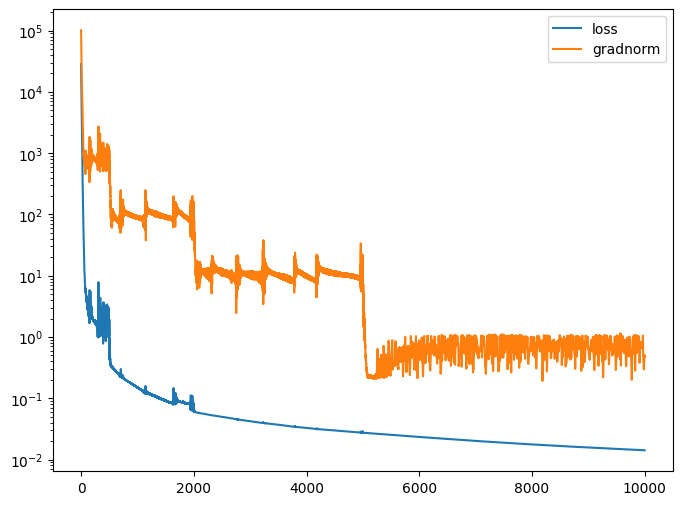

In [13]:
# ANALYSIS

# YOUR ANALYSIS CODE HERE

plt.figure(figsize=(8, 6))
plt.plot(losses, label='loss')
plt.plot(gradnorms, label='gradnorm')   
plt.yscale('log')
plt.legend()
plt.show()

making video:   2%|▏         | 25/1201 [00:01<01:29, 13.15it/s]


KeyboardInterrupt: 

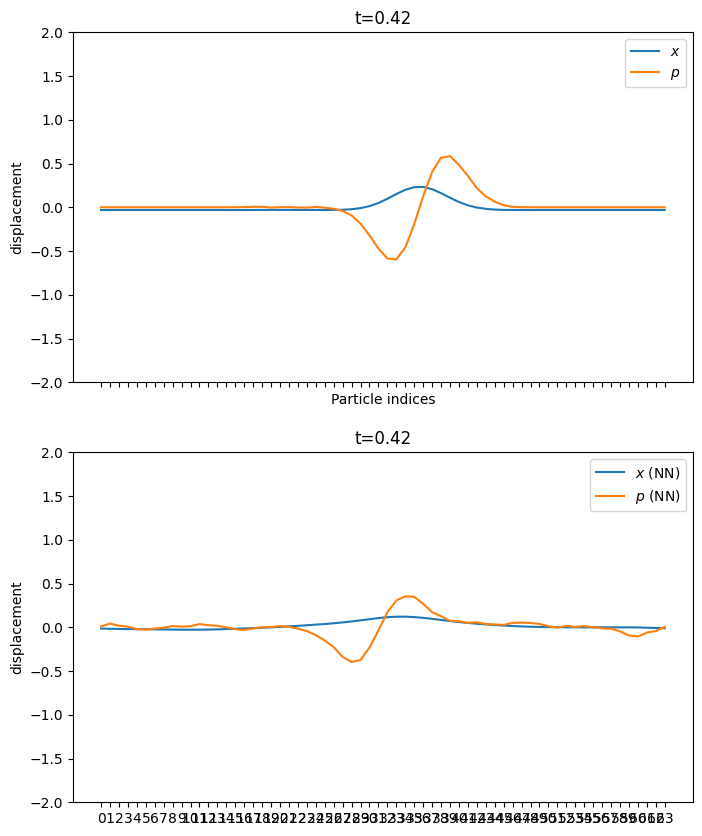

In [15]:
# VISUALIZATION

# YOUR VISUALIZATION FOR ANALYSIS CODE HERE

def make_comparison_video(t, xs, ps, xs_nn, ps_nn, output_path, fps=60):
    """
    t: shape = (num_frames, )
    xs, ps: shape = (num_frames, N)
             시간에 따라 변화하는 xs, ps 데이터
    xs_nn, ps_nn: shape = (num_frames, N)
             아래쪽 subplot에 표시할 추가 데이터
    output_path: 출력할 mp4 파일 경로
    fps: 초당 프레임 수
    """

    num_frames = len(t)
    index = np.arange(N)

    # ---------- (1) 초기 그래프 설정 ----------
    # 전체 figure를 두 개의 subplot(위, 아래)으로 구성합니다.
    fig, (ax_top, ax_bottom) = plt.subplots(2, 1, figsize=(8, 10), sharex=True)
    
    # 상단 subplot: 기존 xs, ps 데이터를 표시
    x_top = xs[0]
    p_top = ps[0]
    line_top1, = ax_top.plot(index, x_top, label='$x$')
    line_top2, = ax_top.plot(index, p_top, label='$p$')
    ax_top.set_xticks(index)
    ax_top.set_xlabel('Particle indices')
    ax_top.set_ylabel('displacement')
    ax_top.set_title(f't={t[0]:.2f}')
    ax_top.set_ylim(-2, 2)
    ax_top.legend()

    # 하단 subplot: 추가 데이터 xs_nn, ps_nn를 표시
    x_bottom = xs_nn[0]
    p_bottom = ps_nn[0]
    line_bottom1, = ax_bottom.plot(index, x_bottom, label='$x$ (NN)')
    line_bottom2, = ax_bottom.plot(index, p_bottom, label='$p$ (NN)')
    ax_bottom.set_xticks(index)
    # ax_bottom.set_xlabel('Particle indices')
    ax_bottom.set_ylabel('displacement')
    ax_bottom.set_title(f't={t[0]:.2f}')
    ax_bottom.set_ylim(-2, 2)
    ax_bottom.legend()

    # ---------- (2) 프레임 업데이트 함수 정의 ----------
    def update(frame):
        current_t = t[frame]
        # 상단 subplot 업데이트: xs, ps
        line_top1.set_ydata(xs[frame])
        line_top2.set_ydata(ps[frame])
        ax_top.set_title(f't={current_t:.2f}')
        
        # 하단 subplot 업데이트: xs_nn, ps_nn
        line_bottom1.set_ydata(xs_nn[frame])
        line_bottom2.set_ydata(ps_nn[frame])
        ax_bottom.set_title(f't={current_t:.2f}')

    # ---------- (3) mp4로 저장 ----------
    writer = FFMpegWriter(fps=fps, metadata=dict(artist='Me'), bitrate=1800)
    with writer.saving(fig, output_path, dpi=100):
        for frame in tqdm.trange(num_frames, desc="making video"):
            update(frame)
            writer.grab_frame()
    
    plt.close(fig)
    
video_path = "./classical_vs_nn.mp4"

xs_nn, ps_nn = jax.vmap(model)(ts.reshape(-1, 1))

make_comparison_video(ts, xs, ps, xs_nn, ps_nn, video_path)
Video(video_path, embed=True)

### Discuss the results (30pts)

DISCUSSING THE ANALYSIS RESULTS (in 200 words)

- 기존 수치해석 방법 이용
  8-th order Explicit Runge-Kutta method인 Dormand-Prince's 8/7 method를 이용하여 미분방정식을 적분함.
  stepsize의 경우 PID controller를 이용해 오차의 절대적인 값과 오차의 증감을 동시에 이용해 적정 stepsize를 효율적으로 찾음
  20초 시뮬레이션에 대략 1초가 걸렸음.
  실제 Analytic solution과 비교해도 큰 오차가 없음

- Neural Network를 이용한 접근
  실제 해가 가지는 꼴에 기반한 (삼각함수의 선형결합) Neural Network를 설계하고, Residual function을 loss로 하여 학습을 진행.
  20초를 시뮬레이션 하기 위해 20분이 걸렸으며 
  실제 Analytic solution과 아주 다른 결과를 보임.

- 두 방법 비교
  Neural network를 사용한 접근이 시간이 오래걸릴 뿐 아니라 더 정확도가 떨어짐.



- NN모델 학습에서 발생한 문제들과 해결 과정
  처음에는 파라미터가 발산해 제대로 학습되지 않음.
  이후 로그를 통해 gradient가 너무 크다는것을 확인, gradient clipping을 통해 해결.
  하지만 이후 학습 속도가 너무 느림(10000 epoch 이후에도 수렴하지 않음) 따라서 Optimizer를 Gradient Descent에서 Adam으로 변경.
  Adam을 사용하니 학습 속도가 빨라지고, Loss가 5배 이상 더 잘 수렴했지만 그래도 loss가 1미만으로 효과적으로 줄어들지 않음.
  learning rate를 500, 2000, 5000 epoch지점에서 1/10씩 감소시키도록 함. 더 낮은 loss달성.
  